In [2]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

# Renormalization and scale invariance

The main ideas behind renormalization is that physical laws should respect certain symmetries and self-similarities.

The tutorial will be divided in 3 parts: 

1.  RGE and strong couping running
2.  DGLAP equation
3.  PDFs features


**NOTE:** 

* Activate your `theory` environment (with LHAPDF)
* Remember to do `git pull`



### A simple example: the Koch curve

A simple system which follows such law is the ["Koch curve"](https://en.wikipedia.org/wiki/Koch_snowflake).
Starting from a equilateral triangle, at each iteration trisect each side, 
including two sides of the small equilateral triangle and again erect an equilateral triangle on the central line segment of each trisected line. 
Carrying on in this way we can obtain a jagged curve with length-scales ranging from the size of the original triangle down to as small as we please.

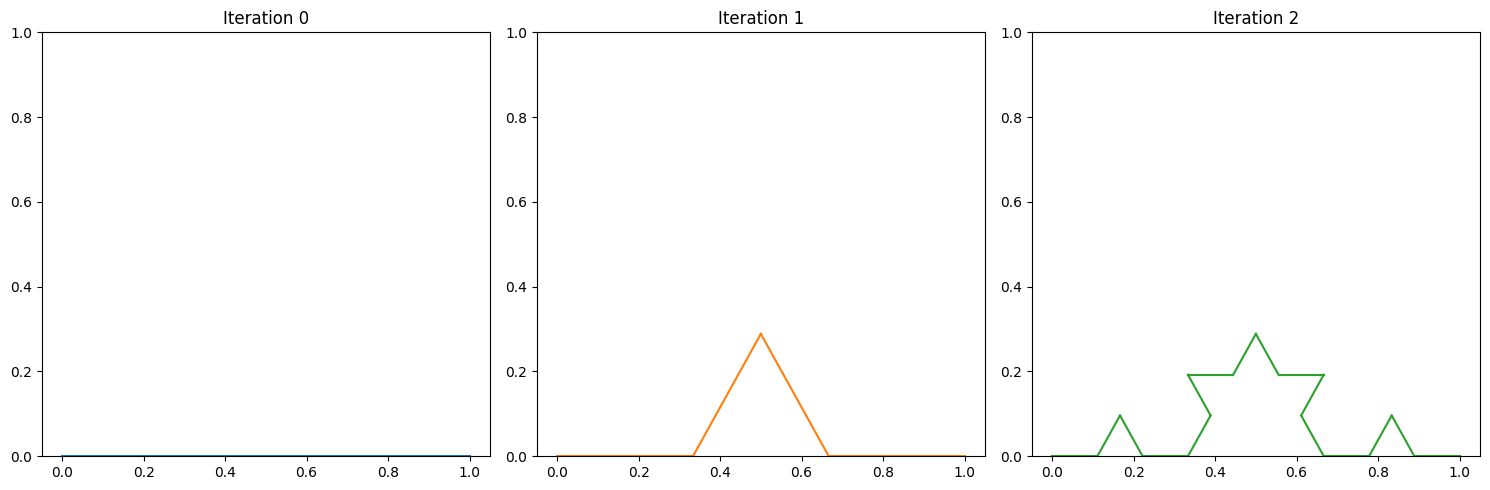

In [4]:
# Define the generating functions for the Koch curve

def rotation(angle: float, x: npt.ArrayLike, r: float) -> npt.ArrayLike:
    """Rotate points by an angle."""
    rot = (
        np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        / r
        @ x.T
    )
    return rot.T


def koch_curve(x: npt.ArrayLike) -> npt.ArrayLike:
    """Add all points in this iteration."""
    r = 3
    # scale by 3
    X1 = x / r
    # rotate by 60°
    X2 = rotation(np.pi / 3, x, r) + [1 / r, 0]
    # rotate by - 60°
    X3 = rotation(-np.pi / 3, x, r) + np.array(
        [np.cos(np.pi / 3), np.sin(np.pi / 3) / r]
    )
    # scale by 3
    X4 = x / r + [2 / r, 0]
    return [X1, X2, X3, X4]


# let's see it in action!
L = 1.0
start_points = np.array([[0, 0], [L, 0]])
iterations = 2
fig, axes = plt.subplots(
    1 + iterations // 3,
    3,
    figsize=(15, 5 * (1 + iterations // 3)),
    clear=True,
    layout="tight",
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# iterate the prescription
for i, ax, col in zip(range(0, iterations + 1), axes.flat, colors):
    if i == 0:
        # at iteration 0 we have a simple line
        all_points = [start_points]
    else:
        new_points = []
        # loop in present point
        for old_point in all_points:
            new_points.extend(koch_curve(old_point))
        # update the list of poitns
        all_points = new_points
    for pts in all_points:
        ax.plot(pts[:, 0], pts[:, 1], color=col)
    ax.set_title(f"Iteration {i}")
    ax.set_ylim(0, L)

Imposing the invariance under infinitesimal dilatation can lead to a Renormalization Group Equation (RGE).

Consider a function describing a physical quantity which depends on a certain characteristic scale $f(L)$, and imagine
it follow the property:

$$ f(\lambda L) = \lambda^n f(L) $$

where $n$ is a number determining the dimensionality of the scaling.
Now, imposing that this property to holds for infinitesimal transformations at every point
you can get a differential equation:

$$ L_1 = \lambda L \equiv L + \delta L $$

$$ f(L_1) - f(L) = (\lambda^n - 1) f(L) = [(\frac{L +\delta L}{L})^n - 1] f(L) \approx n \frac{\delta L}{L} f(L) $$

which implies

$$ \frac{f(L + \delta L) - f(L)}{\delta L} = \frac{n f(L)}{L}  \quad  \to \quad L \frac{df}{dL} = n f(L) $$

The last equation is typical of any system invariant upon dilatation. 

Similarly in QCD once the renormalized fields are defined in terms of the bare quantities and imposing this 
procedure holds at any arbitrary scale it is possible to obtain RGE, which governs the behavior of the physical
quantity when varying the characteristic scale.
In the following tutorial, we will analyze how this particular differential equation can be applied to describe the dependency 
on the energy scale of the running coupling $a_s$ and the Parton Distribution Functions (PDFs)

## The strong coupling running

Chosing the common normalization $a_s = \alpha_s/(4\pi)$ we can write down the the RGE of the QCD strong coupling by:

$$ \mu^2 \frac{d a_s}{d \mu^2} = \beta(a_s) = - \sum_{j=0} \beta_j a_s^{j+2} $$

where $\beta(a_s)$ is calculated perturbatively using Feynman diagrams.

Let's take a closer look to that equation:
- it is a first order ordinary differential equation; so, to solve it we need for sure some boundary value $a_s(\mu_0^2)$ given at a reference scale $\mu_0$
- the dimensions work out fine: $a_s$ is a dimensionless quantities, so are all $\beta_j$ and the differential operator are dimensionless as well

### Asymptotic freedom

Note, that our definition of the coefficients $\beta_j$ excludes an explicit minus sign (other people use other conventions), such that $\beta_0 > 0$.
This means that the strong coupling has a negative derivative (lhs) and thus that it becomes smaller for large scales - people refer to this as [asymptotic freedom](https://en.wikipedia.org/wiki/Asymptotic_freedom) and this is the reason why we do QCD experiments at huge colliders with enormous amount of energy: QCD becomes a perturbative QFT in the high energy region.

On the other hand, we notice that the beta function is strictly negative, so there is no zero derivative, and hence there is no fixed point in QCD at any finite scale (but of course at $\mu^2 = \infty$).

### Resummation and Landau pole

As the differential operator is dimensionless this means that $a_s$ can only depend on a scale ratio and since it is a first order operator it has to be $\log(\mu^2/\mu_0^2)$ - this is however in principle dangerous since the log can become arbitrarily large. This is a common feature in QCD and known as resummation. Let's have a look at the leading order (LO) solution of the RGE
$$ a_s(\mu^2) = \frac{a_s(\mu_0^2)}{1 + \beta_0 a_s(\mu_0^2) \log(\mu^2/\mu_0^2)} $$
which sums all terms $\left(a_s(\mu_0^2) \log(\mu^2/\mu_0^2)\right)^k$ through the geometric series.

Nevertheless, the denominator can be come 0 - and the scale at which this happens is called [Landau pole](https://en.wikipedia.org/wiki/Landau_pole) - since the coupling would become infinite this is surely the latest at which QCD can be treated as perturbative QFT.

We develop the [eko](https://github.com/NNPDF/eko) library to solve the RGE of the strong coupling - let's use it, to plot the strong coupling!

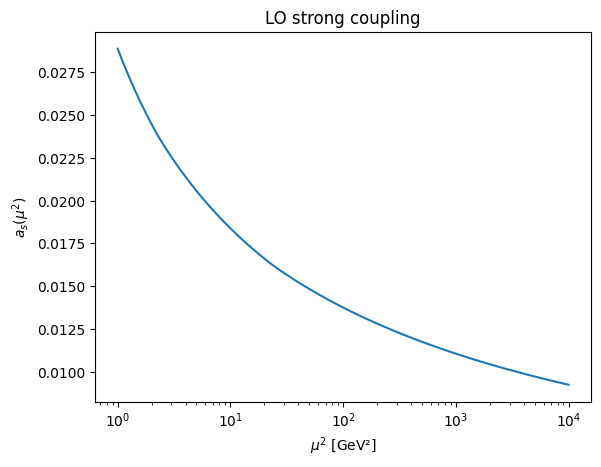

In [4]:
from eko.couplings import CouplingEvolutionMethod, Couplings, CouplingsInfo
from eko.quantities.heavy_quarks import QuarkMassScheme
from eko.beta import beta_qcd

# setup the boundary conditions
ref = CouplingsInfo(
    alphas=0.1180,  # reference scale for QCD coupling
    alphaem=0.007496,  # reference scale for QED coupling
    scale=91.00,  # reference scale
    num_flavs_ref=5,  # number of active flavors at the reference scale
    max_num_flavs=6,  # max flavors allowed
)
order = (1, 0)  # Set perturbative order (QCD, QED)
# create a strong coupling object
sc = Couplings(
    couplings=ref,
    order=order,
    method=CouplingEvolutionMethod.EXACT,  # Set solution method EXACT or EXPANDED
    masses=np.array([1.51, 4.92, 172.5]) ** 2,  # Set heavy quarks masses
    hqm_scheme=QuarkMassScheme.POLE,  # Use POLE masses or MSBAR ?
    thresholds_ratios=np.array([1.0, 1.0, 1.0])
    ** 2,  # Set heavy quarks threshold scales
)


def a_s(Q2: float) -> float:
    """Return :math:`a_s = \alpha_s / (4 \pi)`."""
    return sc.a_s(Q2)


# compute some values of a_s
Q2_grid = np.geomspace(1, 1e4, 100)
as_vals = [a_s(Q2) for Q2 in Q2_grid]

# plot the running strong coupling
plt.close()
plt.plot(Q2_grid, as_vals)
plt.title("LO strong coupling")
plt.xscale("log")
plt.ylabel(r"$a_s(\mu^2)$")
plt.xlabel(r"$\mu^2$ [GeV²]")
plt.show()

### Exercise: LO analytic solution
check analytically, that the solution given above is indeed solving the LO RGE!

### LO numerical solution 
Let's check numerically that our solution solves the RGE! 
for this we are plotting the rhs of the RGE, the beta function, 
against the lhs, which we approximate with a finite difference

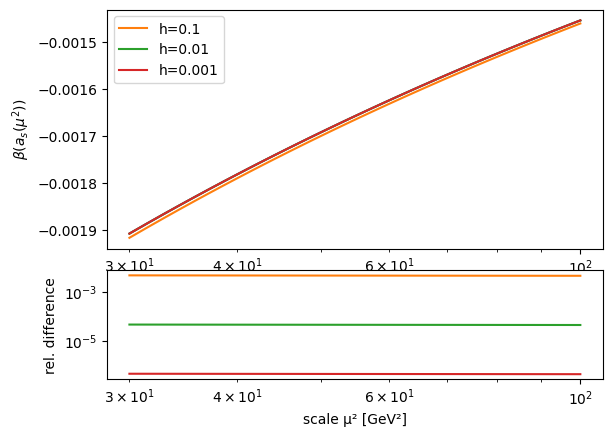

In [5]:
def das_dlogmu(Q2: float, h: float) -> float:
    """Finite difference of strong coupling at the scale Q2 with step h."""
    # as we want a log difference we need to multiply
    return (a_s(Q2 * (1 + h)) - a_s(Q2 * (1 - h))) / (2 * h)


def beta_func(Q2: float) -> float:
    """QCD beta function at scale Q2."""
    a = a_s(Q2)
    return -(a**2) * beta_qcd((2, 0), nf=5)


# first we compute the rhs ...
Q2_grid = np.linspace(30, 100, 50)
rhs = np.array([beta_func(Q2) for Q2 in Q2_grid])
# then, we prepare the plot ...
plt.close()
fig = plt.figure()
ax0 = fig.add_subplot(3, 1, (1, 2))
ax1 = fig.add_subplot(3, 1, 3, sharex=ax0)
ax0.plot(Q2_grid, rhs)
ax0.set_ylabel(r"$\beta(a_s(\mu^2))$")
ax0.set_xscale("log")
ax1.plot([], [])  # do an empty plot to align the colors
# let's try to do a proper limit for the lhs as we ought for a differential - i.e. we take smaller and smaller differences
for h in [1e-1, 1e-2, 1e-3]:
    lhs = np.array([das_dlogmu(Q2, h) for Q2 in Q2_grid])
    ax0.plot(Q2_grid, lhs, label=f"{h=}")
    ax1.plot(Q2_grid, np.abs(rhs / lhs - 1))
ax1.set_ylabel("rel. difference")
ax1.set_yscale("log")
ax1.set_xlabel(r"scale µ² [GeV²]")
ax0.legend()
fig;

### Flavor thresholds and matching conditions

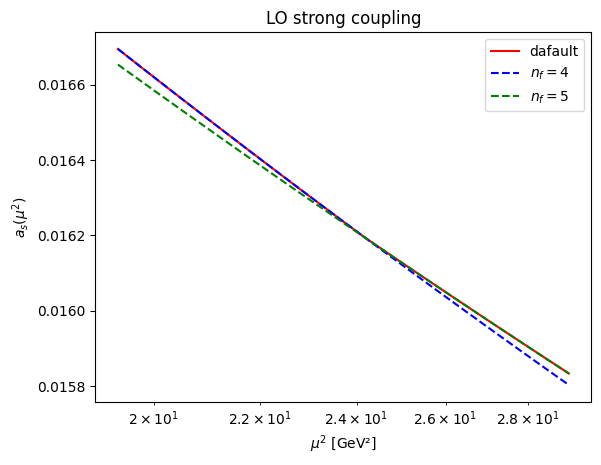

In [7]:
# Let's have a closer look to the region around the bottom mass
mb = 4.92
Q2_grid = np.geomspace(mb**2 * (1.0 - 0.2), mb**2 * (1.0 + 0.2), 100)

# Let's plot again the strong coupling running
plt.close()
plt.plot(Q2_grid, [sc.a_s(Q2) for Q2 in Q2_grid], "r", label="dafault")
# We add two more line, on which we comment in a second
plt.plot(Q2_grid, [sc.a_s(Q2, 4) for Q2 in Q2_grid], "b--", label="$n_f=4$")
plt.plot(Q2_grid, [sc.a_s(Q2, 5) for Q2 in Q2_grid], "g--", label="$n_f=5$")
plt.title("LO strong coupling")
plt.xscale("log")
plt.ylabel(r"$a_s(\mu^2)$")
plt.xlabel(r"$\mu^2$ [GeV²]")
plt.legend()
plt.show()

The problem is that the beta function only holds for a given number of light/active flavors $n_f$ since the beta coefficients depend on $n_f$.
However, in practice the assumptions on how many flavors can be considered light is a dynamic choice - we want to change that according to the scale.
The scale at which we change from one flavor regime to another we refer to as matching scale $\mu_h$ - and a natural choice for the matching scale are the heavy quark masses. In our example above this means that above $m_b$ we solve the beta function with $n_f=5$ (green), but below with with $n_f=4$ (blue).
Note, that our default solution (red) first follows the green curve ($n_f=5$) and then the blue curve ($n_f=4$) and in the opposite region the two do not coincide. Moreover for $\mu=m_b$ all three curves agree.

The exact procedure on how to join two different flavor regimes is refered to as **matching condition**. At LO (as shown here), you only need to change the
coefficients of the beta function, but at higher perturbative orders you may need to do more (i.e. finite corrections have to be applied). Putting the quark thresholds to coincide with the quark masses is a choice and we can in practice choose any value.

### Higher order correction

When we start to consider higher order corrections, i.e. more terms in the beta function, i.e. $\beta_1,\beta_2,\ldots$, we have to remember
that for solving a differential equation, we do not only have to specify a boundary condition, but also an algorithm on how to solve.
Indeed, there is not a unique solution to the beta function beyond leading order. At leading order there is no freedom since we have to resum the dangerous log,
and the only way to do this is by choosing the solution given above. At higher orders, however, we can either choose to keep resumming **all logs** - we refer to this as **"exact" solution** - or we can say, since we're are interested in a perturbative expansion of our observables in the first place,
we only resum the most dangerous log (present at LO) and apart from that we search a perturbative expansion - we refer to this as **"truncated" or "expanded" solution**.
Both solution are true solution, i.e. they solve the beta function, but they differ by higher order terms, i.e. terms we don't know anything about in the first place.

At leading order the exact and the expande solution coincide - since we have to resum the most dangerous log always, but starting from next-to-leading order (NLO) they differ.
In fact, it is no longer possible to write down a closed form exact solution starting from NLO, but one has to choose a numerical approach (e.g. in eko we are using [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp)).
Instead, it is always possible to spell out the truncated solution and in order to find it one can apply an iterative procedure.

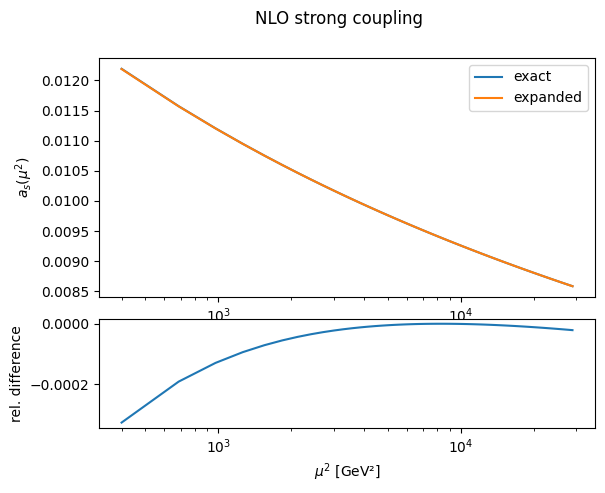

In [6]:
# Let's compare the exact and the expanded solution
sc_nlo_exact = Couplings(
    couplings=ref,
    order=(2, 0),  # Set perturbative order (QCD, QED)
    method=CouplingEvolutionMethod.EXACT,  # Set solution method EXACT or EXPANDED
    masses=np.array([1.51, 4.92, 172.5]) ** 2,  # Set heavy quarks masses
    hqm_scheme=QuarkMassScheme.POLE,  # Use POLE masses or MSBAR ?
    thresholds_ratios=np.array([1.0, 1.0, np.inf])
    ** 2,  # Set heavy quarks threshold scales
)
sc_nlo_expanded = Couplings(
    couplings=ref,
    order=(2, 0),  # Set perturbative order (QCD, QED)
    method=CouplingEvolutionMethod.EXPANDED,  # Set solution method EXACT or EXPANDED
    masses=np.array([1.51, 4.92, 172.5]) ** 2,  # Set heavy quarks masses
    hqm_scheme=QuarkMassScheme.POLE,  # Use POLE masses or MSBAR ?
    thresholds_ratios=np.array([1.0, 1.0, np.inf])
    ** 2,  # Set heavy quarks threshold scales
)
# we collect first the data ...
Q2_grid = np.linspace(20**2, 170**2, 100)
exa = np.array([sc_nlo_exact.a_s(Q2) for Q2 in Q2_grid])
exp = np.array([sc_nlo_expanded.a_s(Q2) for Q2 in Q2_grid])
# and then plot
plt.close()
fig = plt.figure()
fig.suptitle("NLO strong coupling")
ax0 = fig.add_subplot(3, 1, (1, 2))
ax0.plot(Q2_grid, exa, label="exact")
ax0.plot(Q2_grid, exp, label="expanded")
ax0.legend()
ax0.set_ylabel(r"$a_s(\mu^2)$")
ax1 = fig.add_subplot(3, 1, 3, sharex=ax0)
ax1.plot(Q2_grid, exp / exa - 1)
ax1.set_ylabel(r"rel. difference")
ax1.set_xlabel(r"$\mu^2$ [GeV²]")
ax1.set_xscale("log")
fig;

Of course, both solution have to reproduce the reference value and then you can see a (small) deviation between the two if you run for some
bigger distance.

### Exercise: mixed QED QCD running

* Can you plot now the running of $a_{em}$ and $a_s$ with $QED \otimes QCD$ ?
* What is the main difference with respect to the pure$QCD$ one ?

Hint: you should start defining a `CouplingsInfo` and `Couplings` objects